In [57]:
import numpy as np
import tensorflow as tf
import os
import json
import glob
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import sklearn.metrics
from gensim.models import Word2Vec, FastText
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

__type = 'full'
# __type = 'pruned'

Num GPUs Available:  1


In [2]:
def read(path: str):
    codes = []
    tags = []
    paths = []
    for i in tqdm.tqdm(glob.iglob(os.path.join(path, '*.json')), desc='Reading data', total=len(os.listdir(path)) // 3):
        pre, ext = os.path.splitext(i)
        tags.append(json.load(open(i, 'r', encoding='utf-8'))['Tags'])
        statements = open(pre + '.java.ast.stm.flat', 'r', encoding='utf-8').read().strip('\n').split('\n\n')
        codes.append([])
        paths.append(i)
        for stm in statements:
            if len(stm) > 200:
                continue
            codes[-1].append([])
            for line in stm.split('\n'):
                try:
                    token, children = line.split('\t')
                    children = tuple(map(int, children.split())) if children else ()
                    codes[-1][-1].append((token, children))
                except:
                    pass
    return codes, tags, paths

In [3]:
codes, tags, paths = read(f'../data/java/{__type}')

Reading data:   0%|          | 0/18179 [00:00<?, ?it/s]

In [4]:
for code in codes:
    for statement in code:
        for node, children in statement:
            for child in children:
                _ = statement[child]

In [5]:
vocab = set()
for code in codes:
    for statement in code:
        for token, _ in statement:
            vocab.add(token)
vocab = list(vocab)
token_to_id = {j:i for i, j in enumerate(vocab)}
len(vocab)

17667

In [6]:
labels = set()
for tag_list in tags:
    for tag in tag_list:
        labels.add(tag)
labels = list(labels)
label_to_id = {label: i for i, label in enumerate(labels)}
labels

['number theory',
 'math',
 'games',
 'shortest paths',
 'dp',
 'sortings',
 'meet-in-the-middle',
 'bitmasks',
 'flows',
 'trees',
 'interactive',
 'two pointers',
 'geometry',
 'strings',
 'implementation',
 'graphs',
 'dsu',
 'string suffix structures',
 'matrices',
 'combinatorics',
 'data structures',
 'dfs and similar',
 'constructive algorithms',
 'brute force',
 'binary search',
 'hashing',
 'divide and conquer',
 'greedy']

In [7]:
vector_size = 192

In [8]:
w2v_model = Word2Vec.load(f'../embeddings/java/{__type}/stm.w2v')
w2v_wv = w2v_model.wv
w2v_embeddings = np.array([w2v_wv[i] if i in w2v_wv else np.zeros((vector_size,)) for i in vocab])

In [9]:
ft_model = FastText.load(f'../embeddings/java/{__type}/stm.ft')
ft_wv = ft_model.wv
ft_embeddings = np.array([ft_wv[i] if i in ft_wv else np.zeros((vector_size,)) for i in vocab])

In [10]:
print(w2v_embeddings[0][:10])
print(ft_embeddings[0][:10])
print(sum(i in w2v_wv for i in vocab), len(vocab))
print(sum(i in ft_wv for i in vocab), len(vocab))
print(len(w2v_model.wv.key_to_index))
print(len(ft_model.wv.key_to_index))

[-0.05564952  0.02046087  0.10647431 -0.01923187  0.00446714 -0.00236576
  0.00533537 -0.0250175   0.10094999 -0.00020496]
[-0.12320415  0.19479103 -0.41616592  0.6490167   0.5443552  -0.37005484
  0.6032727   0.01902923 -0.35569012 -0.06282882]
17667 17667
17667 17667
21777
21777


In [11]:
vectorized = []
indices = []
he_tags = []

statements_hist = []
nodes_hist = []
max_code_len = -1
max_statement_len = -1

for code in codes:
    vectorized.append([])
    indices.append([])
    max_code_len = max(max_code_len, len(code))
    statements_hist.append(len(code))
    for statement in code:
        vectorized[-1].append([])
        indices[-1].append([])
        max_statement_len = max(max_statement_len, len(statement))
        nodes_hist.append(len(statement))
        for token, _ in statement:
            vectorized[-1][-1].append(token_to_id[token] + 1)
            indices[-1][-1].append(_)

for tag_list in tags:
    he_tags.append([0] * len(labels))
    for tag in tag_list:
        he_tags[-1][label_to_id[tag]] = 1

In [12]:
print(vectorized[0])
print(indices[0])
print(he_tags[:3])

[[6145, 15482, 10013, 14548], [16478, 15482, 10013, 1565, 10677, 10013, 4971, 8064, 10013, 15893, 17071], [10454, 5684, 10013, 5941, 7577, 10013, 5099], [14973, 14515, 4705, 10013, 788], [10454, 5684, 10013, 5941, 7577, 10013, 10639, 10781, 5514, 10044], [246, 1370, 1348, 6023, 819, 9324, 10013, 5099, 10781, 5514, 10044, 9797], [15806, 1370, 1348, 6023, 780, 9324, 10013, 5099, 9797, 9797], [14973, 14515, 6871, 10013, 5121, 10219, 10781, 5514, 10044], [13256, 7244, 6023, 12844, 9324, 10013, 5099], [14973, 14515, 6871, 10013, 5121, 10219, 10781, 5514, 10044], [13256, 9324, 10013, 10639, 3034, 16412, 6023, 6880], [14973, 14515, 6871, 10013, 14828, 10219, 10781, 5514, 10044], [14973, 14515, 9120, 10013, 14054, 10219, 9324, 10013, 10639]]
[[(1,), (2,), (3,), ()], [(1, 10), (2, 4), (3,), (), (5, 7), (6,), (), (8,), (9,), (), ()], [(1, 4), (2,), (3,), (), (5,), (6,), ()], [(1, 3), (2,), (), (4,), ()], [(1, 4), (2,), (3,), (), (5, 7), (6,), (), (8,), (9,), ()], [(1, 11), (2,), (3, 5, 8), (4,),

56.77606028934485
999


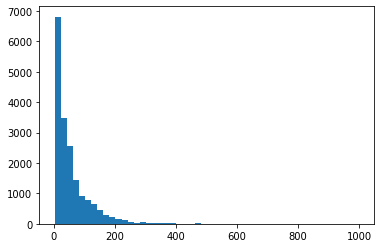

In [13]:
plt.hist(statements_hist, bins=50)
print(np.mean(statements_hist))
print(max_code_len)

8.177879379769255
19


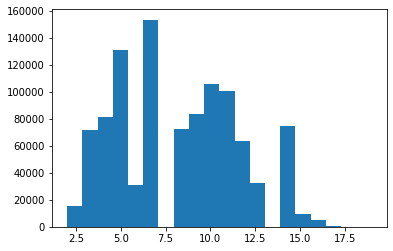

In [14]:
plt.hist(nodes_hist, bins=20)
print(np.mean(nodes_hist))
print(max_statement_len)

(array([1.405278e+06, 1.590000e+02, 6.000000e+00, 4.000000e+00,
        0.000000e+00, 0.000000e+00, 7.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 2.000000e+00]),
 array([2.00000e+00, 1.02850e+02, 2.03700e+02, 3.04550e+02, 4.05400e+02,
        5.06250e+02, 6.07100e+02, 7.07950e+02, 8.08800e+02, 9.09650e+02,
        1.01050e+03, 1.11135e+03, 1.21220e+03, 1.31305e+03, 1.41390e+03,
        1.51475e+03, 1.61560e+03, 1.71645e+03, 1.81730e+03, 1.91815e+03,
        2.01900e+03]),
 <BarContainer object of 20 artists>)

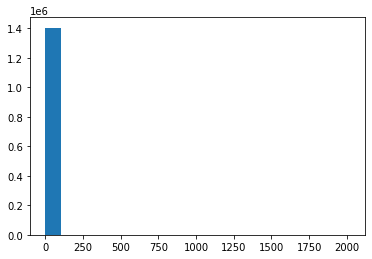

In [162]:
plt.hist(nodes_hist, bins=20)

In [44]:
def get_embedding(shape: tuple, vocab: list, input_size: int, output_size: int, shift: int = 0, pre_trained = None):
    embedding = tf.keras.layers.Embedding(input_size, output_size, name='Tree_Embedding', mask_zero=True)
    embedding.build(shape)
    embedding.trainable = pre_trained is None
    if pre_trained is not None:
        weights = np.zeros((input_size, output_size))
        for i, token in enumerate(vocab):
            try:
                weights[i + shift] = pre_trained[i]
            except:
                pass
        embedding.set_weights([weights])
    return embedding


def get_embedding_encoder(input_shape: tuple, output_size: int):
    inputs = tf.keras.layers.Input(input_shape)
    outputs = tf.keras.layers.Dense(output_size)(inputs)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name='Embedding_Encoder')


def get_statement_encoder(input_shape: tuple, filters: int):
    inputs = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv1D(filters=filters, kernel_size=3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.Conv1D(filters=filters, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Lambda(lambda tensor: tf.math.reduce_max(tensor, axis=2))(x)
    return tf.keras.Model(inputs=inputs, outputs=x, name='Statement_Encoder')


def get_tree_encoder(input_shape: tuple, predict: bool = False):
    inputs = tf.keras.layers.Input(input_shape, name='Inputs')
    x = tf.keras.layers.Dropout(0.1, name='Embedding_Dropout')(inputs)
    x = tf.keras.layers.Bidirectional(
            tf.keras.layers.RNN(tf.keras.layers.GRUCell(units=128)),
        name='Double_Bidirectional_GRU')(x)
    if predict:
        x = tf.keras.layers.Dense(units=len(labels), activation='sigmoid', name='Prediction')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=x, name='Tree_Encoder')


def get_combined_model(input_shape: tuple, embedding, encoder, statement_encoder, tree_encoder):
    inputs = tf.keras.layers.Input(input_shape, name='Statement_Trees')
    x = embedding(inputs)
    x = encoder(x)
    x = statement_encoder(x)
    x = tree_encoder(x)
    x = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.swish, name='Dense')(x)
    x = tf.keras.layers.Dense(units=len(labels), activation='sigmoid', name='Prediction')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=x, name='PSLNN_Combined')
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model


def get_flat_model(input_shape: tuple, embedding):
    inputs = tf.keras.layers.Input(input_shape, dtype=tf.int32, name='Nodes')
    embedded = embedding(inputs)
    dropout = tf.keras.layers.Dropout(0.5, name='Embedding_Dropout')(embedded)

    n_layers = 2
    kernels = [3, 5, 7]
    layers = []

    for k in kernels:
        x = dropout
        n = x.shape[-1]
        for i in range(n_layers):
            x = tf.keras.layers.Conv1D(n, k, activation=tf.keras.activations.swish, padding='same', name=f'Conv1D_{k}_{n}')(x)
            x = tf.keras.layers.BatchNormalization(name=f'Batch_Norm_{k}_{n}')(x)
            n *= 2

        x = tf.keras.layers.GlobalMaxPooling1D(name=f'Max_Pool_{k}')(x)
        layers.append(x)

    x = tf.keras.layers.Concatenate(axis=-1, name='Pool_Concatenate')(layers)
    x = tf.keras.layers.Dropout(0.5, name='Concatenate_Dropout')(x)
    x = tf.keras.layers.Dense(units=512, activation=tf.keras.activations.swish, name=f'Dense')(x)
    x = tf.keras.layers.Dense(units=len(labels), activation='sigmoid', name='Prediction')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=x, name='PSLNN_Flat')
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.summary()
    return model

In [102]:
class StatementDataset(tf.keras.utils.Sequence):
    def __init__(self, vectorized, indices, he_tags, batch_size):
        self.vectorized = vectorized
        self.indices = indices
        self.he_tags = he_tags
        self.batch_size = batch_size
        self.shuffle()

    def __len__(self):
        return (len(self.vectorized) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        vectorized_batch = vectorized[start:end]
        indices_batch = indices[start:end]
        he_tags_batch = he_tags[start:end]

        max_len = max(len(j) for i in vectorized_batch for j in i)
        code_batch = tf.keras.preprocessing.sequence.pad_sequences(
            [tf.keras.preprocessing.sequence.pad_sequences(i, padding='post', maxlen=max_len) for i in vectorized_batch],
            padding='post'
        )
        code_batch = code_batch[:,1:129]
        indices_batch = [[i[j] for j in range(1, min(129, len(i)))] for i in indices_batch]
        return (code_batch, indices_batch), he_tags_batch

    def shuffle(self):
        indices = np.arange(len(self.vectorized))
        np.random.shuffle(indices)

        self.vectorized = [self.vectorized[i] for i in indices]
        self.indices = [self.indices[i] for i in indices]
        self.he_tags = [self.he_tags[i] for i in indices]

    def on_epoch_end(self):
        self.shuffle()

In [105]:
shift = 1
emb_input_size = len(vocab) + shift
emb_output_size = 192
emb_encoder_output_size = 128
embedding = get_embedding(shape=(None, None, None),
                          input_size=emb_input_size,
                          output_size=emb_output_size,
                          pre_trained=ft_embeddings,
                          shift=1,
                          vocab=vocab)
embedding_encoder_model = get_embedding_encoder(input_shape=(None, None, emb_output_size),
                                                output_size=emb_encoder_output_size)
tree_encoder_model = get_tree_encoder(input_shape=(None, emb_encoder_output_size),
                                      predict=True)


def cross_entropy(y_true, y_pred):
    return tf.math.reduce_mean(-tf.math.reduce_sum(y_true * tf.math.log(y_pred), axis=-1))


def tree_encoding_step(optimizer, code_batch, indices_batch, he_tags_batch):
    with tf.GradientTape() as tape:
        # b: code_batch length
        # n: code_batch.shape[1] -- number of sequences in code
        # m: code_batch.shape[2] -- number of statements in sequence
        # e: embedding vector size
        # code_batch: (b, n, m,)
        # encoded: (b, n, m, e,)
        encoded = embedding_encoder_model(embedding(code_batch), training=True)
        encoded_as_list = [[[encoded[i, j, k] for k in range(code_batch.shape[2])] for j in range(code_batch.shape[1])] for i in range(len(code_batch))]
        # statement encoding over known embeddings
        for i in range(len(indices_batch)):
            for j in range(len(indices_batch[i])):
                for k in range(len(indices_batch[i][j]) - 1, -1, -1):
                    children = indices_batch[i][j][k]
                    if not children:
                        continue
                    encoded_as_list[i][j][k] = tf.reduce_sum([
                        encoded_as_list[i][j][k],
                        *(encoded_as_list[i][j][l] for l in children)
                    ], axis=0)
        pooled = tf.math.reduce_max(encoded_as_list, axis=2)
        logits = tree_encoder_model(pooled, training=True)
        loss_value = tf.math.reduce_mean(tf.keras.losses.binary_crossentropy(he_tags_batch, logits))
        grads = tape.gradient(loss_value, tree_encoder_model.trainable_weights + embedding_encoder_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, tree_encoder_model.trainable_weights + embedding_encoder_model.trainable_weights))
    return loss_value


def models_parallel_train(epochs: int, batch_size: int):
    optimizer = tf.keras.optimizers.Adamax(learning_rate=2e-3)
    statement_dataset = StatementDataset(vectorized, indices, he_tags, batch_size=batch_size)
    for epoch in tqdm.trange(epochs):
        pbar = tqdm.tqdm(enumerate(statement_dataset), total=len(statement_dataset))
        for step, ((code_batch, indices_batch), he_tags_batch) in pbar:
            loss_value = tree_encoding_step(optimizer, code_batch, indices_batch, he_tags_batch).numpy()
            pbar.set_description(str(loss_value))
        statement_dataset.on_epoch_end()

In [ ]:
models_parallel_train(epochs=1, batch_size=4)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4545 [00:00<?, ?it/s]

In [ ]:
embedding_encoder_model.save('java_embedding_encoder_weights')
tree_encoder_model.save('java_statement_tree_encoder_weights')

In [99]:
def predict_on_batch(code_batch, indices_batch):
    encoded = embedding_encoder_model(embedding(code_batch))
    encoded_as_list = [[[encoded[i, j, k] for k in range(code_batch.shape[2])] for j in range(code_batch.shape[1])] for i in range(len(code_batch))]
    for i in range(len(indices_batch)):
        for j in range(len(indices_batch[i])):
            for k in range(len(indices_batch[i][j]) - 1, -1, -1):
                children = indices_batch[i][j][k]
                if not children:
                    continue
                encoded_as_list[i][j][k] = tf.reduce_sum([
                    encoded_as_list[i][j][k],
                    *(encoded_as_list[i][j][l] for l in children)
                ], axis=0)
    pooled = tf.math.reduce_max(encoded_as_list, axis=2)
    logits = tree_encoder_model(pooled)
    return logits

In [ ]:
# def statement_encoding(epochs: int, batch_size: int):
#     loss_fn = tf.keras.losses.CategoricalCrossentropy()
#     optimizer = tf.keras.optimizers.Adam()
#
#     for epoch in tqdm.trange(epochs):
#         vectorized_batches = batch(vectorized, batch_size)
#         indices_batches = batch(indices, batch_size)
#         he_tags_batches = batch(he_tags, batch_size)
#         pbar = tqdm.tqdm(enumerate(zip(vectorized_batches, indices_batches, he_tags_batches)), total=len(vectorized) // batch_size)
#         for step, (vectorized_batch, indices_batch, he_tags_batch) in pbar:
#             max_len = max(len(j) for i in vectorized_batch for j in i)
#             code_batch = tf.keras.preprocessing.sequence.pad_sequences(
#                 [tf.keras.preprocessing.sequence.pad_sequences(i, padding='post', maxlen=max_len) for i in vectorized_batch],
#                 padding='post'
#             )
#             with tf.GradientTape() as tape:
#                 # m: max_len
#                 # code_batch: b x n x m
#                 # encoded: b x n x m x e
#                 encoded = encoder_model(embedding(code_batch), training=True)
#                 pooled = statement_encoder_model(encoded, training=True)
#                 #logits = model(pooled, training=True)
#                 #loss_value = loss_fn(he_tags_batch, logits)
#
#             #grads = tape.gradient(loss_value, model.trainable_weights + encoder_model.trainable_weights)
#             #optimizer.apply_gradients(zip(grads, model.trainable_weights + encoder_model.trainable_weights))
#             #pbar.set_description(str(loss_value.numpy()))

In [ ]:
# class FlatteningDataset(tf.keras.utils.Sequence):
#     def __init__(self, vectorized, indices, he_tags, batch_size):
#         self.vectorized = vectorized
#         self.indices = indices
#         self.he_tags = he_tags
#         self.batch_size = batch_size
#
#     def __len__(self):
#         return (len(self.vectorized) + self.batch_size - 1) // self.batch_size
#
#     def __getitem__(self, idx):
#         start = idx * self.batch_size
#         end = (idx + 1) * self.batch_size
#         vectorized_batch = vectorized[start:end]
#         indices_batch = indices[start:end]
#         he_tags_batch = he_tags[start:end]
#
#         vectorized_batch = [[st for sequence in code for st in sequence] for code in vectorized_batch]
#         code_batch = tf.keras.preprocessing.sequence.pad_sequences(vectorized_batch, maxlen=1024, padding='post')
#         return code_batch, np.array(he_tags_batch)
#
#     def on_epoch_end(self):
#         pass

# shift = 1
# emb_input_size = len(vocab) + shift
# emb_output_size = 192
#
# flat_model = get_flat_model(input_shape=(None,),
#                             embedding=get_embedding(shape=(None, None),
#                                                     vocab=vocab,
#                                                     input_size=emb_input_size,
#                                                     output_size=emb_output_size,
#                                                     shift=shift,
#                                                     pre_trained=ft_embeddings))
#
# flat_dataset = FlatteningDataset(vectorized, indices, he_tags, batch_size=8)
#
# emb_encoder_output_size = 128